# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
# Load pickled data
import pickle

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [2]:
### Replace each question mark with the appropriate value.
import numpy as np

# Number of training examples
n_train = len(X_train)

# Number of testing examples.
n_test = len(X_test)

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
# See numpy.unique : https://docs.scipy.org/doc/numpy/reference/generated/numpy.unique.html
unique_items, counts = np.unique(y_train, return_counts=True) 
n_classes = len(counts)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

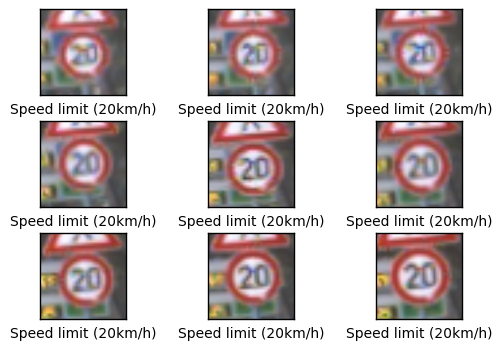

In [3]:
### Data exploration visualization goes here.
import matplotlib.pyplot as plt
import csv
# Visualizations will be shown in the notebook.
%matplotlib inline

# Create figure with 3x3 sub-plots.
def plot_images(images, classes, labels, gray):
    fig, axes = plt.subplots(3, 3)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        # Plot image.
        if(gray):
            ax.imshow(images[i], cmap='gray')
        else:
            ax.imshow(images[i])
        xlabel = labels[classes[i]][1]
        ax.set_xlabel(xlabel)
        
        # Remove pixels legend x and legend y.
        ax.set_xticks([])
        ax.set_yticks([])

def read_csv(path):
    sign_names = []
    with open(path, 'r') as f:
        reader = csv.reader(f)
        f.readline() # Skip first line
        for row in reader:
            sign_names.append(row)
    return sign_names

labels = read_csv('signnames.csv')
plot_images(X_train, y_train, labels, False)
plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [4]:
### Preprocess the data here.
import cv2

# Set a gray scale filter to the image
def to_gray_scale(img_data):
    return cv2.cvtColor(img_data.astype(np.uint8), cv2.COLOR_RGB2GRAY)

# Normalize image by Min-Max scaling
def normalize_gray_scale(img_data):
    a = 0.1
    b = 0.9
    greyscale_min = 0
    greyscale_max = 255
    return a + ( ( (img_data - greyscale_min)*(b - a) )/( greyscale_max - greyscale_min ) )

# Define the new matrix normalized and transform to gray_scale (also smooth out with Gaussian Blur)
X_train_gray = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])
X_train_normalized = np.zeros([X_train.shape[0], X_train.shape[1], X_train.shape[2]])

# Iterate through each image of the training set to apply the transformation
for image in range (0, n_train):
    X_train_gray[image] = to_gray_scale(X_train[image])
    X_train_normalized[image] = normalize_gray_scale(X_train_gray[image])

print(X_train.shape)
print(X_train_normalized.shape)

(39209, 32, 32, 3)
(39209, 32, 32)


### Question 1 

<b>Answer</b>
I first choose to apply a grey_scale filter on the data. Indeed, from the [article](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) of Pr. Yann Le Cunn, we learnt that by doing so, the general performance of his model improved. 
Then, I normalized the data using a [mean normalization](https://en.wikipedia.org/wiki/Feature_scaling) to a range of [0.1, 0.9]. I normalized the data so that each feature contributes approximately proportionately to the computation of the cost function. This avoid the cost function to be driven by some <i>ab-normal</i> features.
I also use a dropout between layer 1 and 2, but this has not improved the accuracy. Nonetheleess, it is commented so you can try by de-commenting it. 

In [5]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.

from sklearn import cross_validation

# The training set is split into trainind validation set
# The training set represents 80% of the whole training set
# The Validation set represents the 20% remaining
# The test set is letf untouched. 

X_train, X_val, y_train, y_val = cross_validation.train_test_split(X_train_normalized, y_train, test_size=0.2)

print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)


(31367, 32, 32)
(7842, 32, 32)
(31367,)
(7842,)


### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

<b>Answer</b>
I choose to split the original training set into 2 parts:
1. <b>Training set</b>
2. <b>Validation set</b> <br/>

The training set counts for 80% of the total of the original training set while the validation set counts for 20%. 
This kind of split is considered to be a [good split](https://stackoverflow.com/questions/13610074/is-there-a-rule-of-thumb-for-how-to-divide-a-dataset-into-training-and-validatio) . <br/>
I choose to let the original test set untouched.


In [6]:
### Define your architecture here.
import tensorflow as tf
from sklearn import preprocessing

BATCH_SIZE = 256
EPOCHS = 30

def one_hot_encoding(y_tr, n_classes):
    OHC = preprocessing.OneHotEncoder()
    Y_ohc = OHC.fit(np.arange(n_classes).reshape(-1, 1))
    Y_labels = Y_ohc.transform(y_tr.reshape(-1, 1)).toarray()
    return Y_labels

# Define the convolutional network - follow the structure of LeNet()
def conv_net(x):
    # Reshape from 2D to 4D. This prepares the data for
    # convolutional and pooling layers.
    x = tf.reshape(x, (-1, 32, 32, 1))
    # Pad 0s to 32x32. Centers the digit further.
    # Add 2 rows/columns on each side for height and width dimensions.
    x = tf.pad(x, [[0, 0], [2, 2], [2, 2], [0, 0]], mode="CONSTANT")
    
    # First Layer : 32x32x6
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 1, 6)))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1 = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b
    conv1 = tf.nn.relu(conv1)

    # 14x14x6
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    #conv1 = tf.nn.dropout(conv1, keep_prob)
    
    # 10x10x16
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16)))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2 = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b

    # 5x5x16
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    # conv2 = tf.nn.dropout(conv2, keep_prob)

    # Flatten
    fc1 = tf.contrib.layers.flatten(conv2)
    # (5 * 5 * 16, 120)
    fc1_shape = (fc1.get_shape().as_list()[-1], 120)

    fc1_W = tf.Variable(tf.truncated_normal(shape=(fc1_shape)))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1 = tf.matmul(fc1, fc1_W) + fc1_b
    fc1 = tf.nn.relu(fc1)

    fc2_W = tf.Variable(tf.truncated_normal(shape=(120, n_classes)))
    fc2_b = tf.Variable(tf.zeros(n_classes))
    return tf.matmul(fc1, fc2_W) + fc2_b

def get_next_batch(x, y, batch_size):
    batch_mask = np.random.choice(len(x), batch_size, replace=False)
    x_train = x[batch_mask]
    y_train = y[batch_mask]
    return x_train, y_train

# Define the inputs and outputs, and the neural net
X = tf.placeholder(tf.float32, (None, 32, 32))
y = tf.placeholder(tf.float32, (None, n_classes))

# Define dropout keep_prob
# keep_prob=tf.placeholder(tf.float32)

# Fully connected layer 2 which is the output from conv_net()
fc2 = conv_net(X)

# Cost function and data about accuracy 
loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(fc2, y))
optimizer = tf.train.AdamOptimizer()
train_op = optimizer.minimize(loss_op)
correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
accuracy_op = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._

<b>Answer</b>
I decided to use a Convolutional Network since it has been advised by this notebook. This network is composed of the following layers (in this orfer): 

- First Layer: Convolutional layer, output of size 32x32x6
- Max pooling layer Output of size 14x14x6
- Second layer Convolutional layer, output of size 10x10x16
- Max pooling layer Output of size 5x5x6
- Flatten Layer Flatten shape to 1D
- Fully connected layer 1 Output of size 120
- Fully connected layer 2 Output of size n_classes (43 in that case)

In [7]:
### Train your model here.

# Add a saver to save the trained model
saver = tf.train.Saver()

# One-hot encode the labels:
y_train_one_hot = one_hot_encoding(y_train, n_classes)
y_val_one_hot = one_hot_encoding(y_val, n_classes)

with tf.Session() as sess:    
    sess.run(tf.initialize_all_variables())
    steps_per_epoch = len(X_train) // BATCH_SIZE
    num_examples = steps_per_epoch * BATCH_SIZE

    # Train model
    for i in range(EPOCHS):
        for step in range(steps_per_epoch):
            batch_x, batch_y = get_next_batch(X_train, y_train_one_hot, BATCH_SIZE)
            #loss = sess.run(train_op, feed_dict={X: batch_x, y: batch_y, keep_prob: 0.7})
            loss = sess.run(train_op, feed_dict={X: batch_x, y: batch_y})

        #c = sess.run(loss_op, feed_dict={X: batch_x, y: batch_y, keep_prob: 0.7})
        c = sess.run(loss_op, feed_dict={X: batch_x, y: batch_y})
        print("Epoch:", '%04d' % (i+1), "cost =", "{:.9f}".format(c))

    # Test model
    correct_prediction = tf.equal(tf.argmax(fc2, 1), tf.argmax(y, 1))
    # Calculate accuracy
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    #print("Accuracy:", accuracy.eval({X: X_val, y: y_val_one_hot, keep_prob: 1.0}))
    print("Accuracy:", accuracy.eval({X: X_val, y: y_val_one_hot}, session=sess))
    # Save trained model
    save_path = saver.save(sess, "trained-model.ckpt")

Epoch: 0001 cost = 401.402709961
Epoch: 0002 cost = 273.257507324
Epoch: 0003 cost = 209.588119507
Epoch: 0004 cost = 144.963836670
Epoch: 0005 cost = 91.628036499
Epoch: 0006 cost = 39.883983612
Epoch: 0007 cost = 10.250490189
Epoch: 0008 cost = 4.836092949
Epoch: 0009 cost = 4.513467789
Epoch: 0010 cost = 4.062741756
Epoch: 0011 cost = 4.107648373
Epoch: 0012 cost = 4.022188187
Epoch: 0013 cost = 3.660353661
Epoch: 0014 cost = 3.691973925
Epoch: 0015 cost = 3.698225498
Epoch: 0016 cost = 3.471302509
Epoch: 0017 cost = 3.335628510
Epoch: 0018 cost = 3.504329681
Epoch: 0019 cost = 3.312382221
Epoch: 0020 cost = 3.381785870
Epoch: 0021 cost = 3.402818203
Epoch: 0022 cost = 3.427330494
Epoch: 0023 cost = 3.399874210
Epoch: 0024 cost = 3.380398273
Epoch: 0025 cost = 3.623803139
Epoch: 0026 cost = 3.458865643
Epoch: 0027 cost = 3.469977617
Epoch: 0028 cost = 3.361679554
Epoch: 0029 cost = 3.497636080
Epoch: 0030 cost = 3.438528776
Accuracy: 0.0867126


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** I use the [AdamOptimizer](https://www.tensorflow.org/versions/r0.12/api_docs/python/train.html#AdamOptimizer) with the default learnig rate of 0.001. With this learning rate, I achieve a maximum accuracy of a bit more that 86% (86.71%) during my first try.
With the same optimizer, but a learning rate of 0.0001, my accuracy decreased to 18%, which means the learning rate is to small. 

<img src="best.png"></img>

The different test of learning rate value have been tested with a batch size of 256, with 50 epochs. 
The possible solution to obtain a lower cost would be :
- Do a better pre-processing of the inputs (YUV space)
- Generate more data (twist a bit the traffic signs, apply some more filters, move all images to 2 pixels to the left/right ...)
- Use another [optimizer](https://www.tensorflow.org/versions/r0.12/api_docs/python/train.html)

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:**
The first thing I have done is implememt the LeNet() Convulotional Network as adivised by the course [here](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81). 

I then begin the game or trial and error. Indeed, I didn't understood some basics concepts and ask many questions on the forums to get some help. My very first issue was an error when converting my images to gray, the forum has bee very helpful to figure out the [solution](https://carnd-udacity.atlassian.net/wiki/questions/26216649/problem-when-converting-to-gray).  

I also encounter some diffuculties with an 'out of bound' exception which was kindly explained by Mr. Patrick Kern [here](https://carnd-udacity.atlassian.net/wiki/questions/26218448/random-batching---index-out-of-bounds). 

After all my questions (and the time I spent on this project), I was able to acquire knew knwoledge and even answer to a [question](https://carnd-udacity.atlassian.net/wiki/display/CAR/questions/26220944/answers/26221255) regarding the shape of the logits and the labels. 

I do think that a CNN fits this kind of issue because it can recognize shape. Unlike a simple Deep Neural Network, which will analyze the image pixel by pixels, a CNN will be able to construct itself a representation of the image based on the shape it will recognized. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

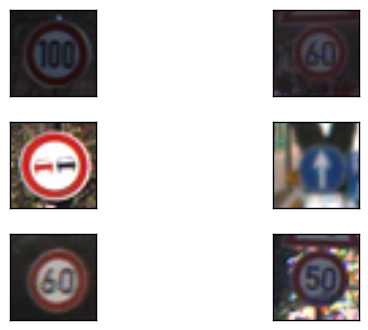

In [8]:
### Load the images and plot them here.
import os
import matplotlib.image as mpimg

def plot_test_images(imgs):
    fig, axes = plt.subplots(3, 2)
    fig.subplots_adjust(hspace=0.3, wspace=0.3)

    for i, ax in enumerate(axes.flat):
        ax.imshow(imgs[i])
        
        # Remove pixels legend x and legend y.
        ax.set_xticks([])
        ax.set_yticks([])

path_folder = "other_images/"
filenames = ["00000.png", "00001.png", "00002.png", "00003.png", "00005.png", "00015.png"]

test_images = np.array([mpimg.imread(path_folder + "/" + file) for file in filenames])
new_labels = np.array([7., 3., 9., 35., 3., 2.], np.float)

plot_test_images(test_images)
plt.show()

    

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:**
The images I used to tests this Neural Network are also images from the German Traffic sign [dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset), which make the probability for the algorithm to correctly guess the outputs since it is also German traffic signs. 

In this dataset, there is indeed some images which could be difficult to guess, for several reason: 
- They are fuzy 
- The luminosity is not ideal (either too bright or too dark), and it is difficult (even for a human), to distinct it
- The traffic sign is not the only only in the picture (see 0051.ppm)

In [9]:
### Run the predictions here.

# Process Images 
test_images_gray = np.zeros([test_images.shape[0], test_images.shape[1], test_images.shape[2]])
test_images_normalized = np.zeros([test_images.shape[0], test_images.shape[1], test_images.shape[2]])

for image in range (0, len(test_images)):
    test_images_gray[image] = to_gray_scale(test_images[image])
    test_images_normalized[image] = normalize_gray_scale(test_images_gray[image])
    
# One Hot encode the new labels
new_labels_on_hot = one_hot_encoding(new_labels, n_classes)

with tf.Session() as sess: 
    restored_saver = tf.train.import_meta_graph('trained-model.ckpt.meta')
    restored_saver.restore(sess, tf.train.latest_checkpoint('./'))

    print(accuracy.eval({X: test_images_normalized, y: new_labels_on_hot}, session=sess))
    save_path = saver.save(sess, "trained-model.ckpt")



0.0


### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:**
The model is has been able to recognize at most 16% of the new data. I used the signnames.csv to indicate the reight labels. 
To enhance it, we could improve the model by fine tuning the parameters.  


In [10]:
### Visualize the softmax probabilities here.

with tf.Session() as sess: 
    restored_saver = tf.train.import_meta_graph('trained-model.ckpt.meta')
    restored_saver.restore(sess, tf.train.latest_checkpoint('./'))
    softmax_predictions = tf.nn.softmax(fc2)
    topFive = tf.nn.top_k(softmax_predictions, k=5, sorted=True, name=None)
    
    print("Probabilities")
    probabilities = topFive.values.eval({X: test_images_normalized}, session=sess)
    print(probabilities)
    
    print("Class")
    classes = topFive.indices.eval({X: test_images_normalized}, session=sess)
    print(classes)

Probabilities
[[ 0.43929181  0.15982985  0.11407959  0.10177194  0.03909224]
 [ 0.43929181  0.15982985  0.11407959  0.10177194  0.03909224]
 [ 0.2329403   0.17926499  0.14184125  0.12921932  0.06584409]
 [ 0.4445551   0.15895727  0.11318579  0.10092542  0.03851369]
 [ 0.43929181  0.15982985  0.11407959  0.10177194  0.03909224]
 [ 0.42268568  0.162488    0.11685816  0.10441138  0.04094734]]
Class
[[17 13 38 10  1]
 [17 13 38 10  1]
 [17 13 38 10  1]
 [17 13 38 10  1]
 [17 13 38 10  1]
 [17 13 38 10  1]]


### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:**

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.